# Goal
To make a translator that is able to detect the text from an image, identify its language, convert it to English and convert to audio output.

# Part 1: Optical Character Recognition

## Install Library

In [1]:
# !pip install pytesseract
# !pip install opencv-python

## Import Libraries

In [2]:
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Set Configuration Settings
- The --oem argument, or OCR Engine Mode, controls the type of algorithm used by Tesseract. 
- The --psm controls the automatic Page Segmentation Mode used by Tesseract.

In [3]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'

### Import and Display Image

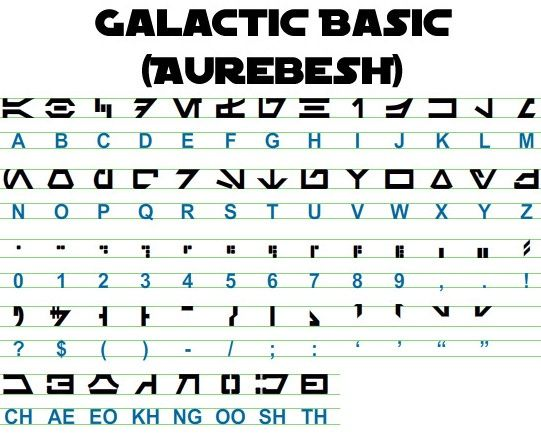

In [4]:
## Import Image and Test
image = cv2.imread('aurebesh.jpg')

#Display Image
from IPython.display import Image
Image(filename='aurebesh.jpg') 

## Preprocessing for Tesseract
- To avoid all the ways your tesseract output accuracy can drop, we need to ensure that image is pre-processed
- E.g Rescaling, Binarisation, Noise Removal, Deskewing etc

In [5]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

## Apply Image Pre-processing

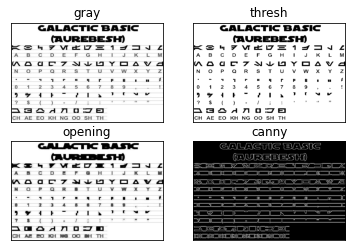

In [6]:
gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

titles = ["gray", "thresh", "opening", "canny"]
images = [gray, thresh, opening, canny]

for i in range(len(images)):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255, aspect='auto')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

## Text identified after Post-Processing

In [7]:
#Set Tesseract path in script to avoid error
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#### Original Image

In [8]:
print(pytesseract.image_to_string(image, config=custom_config))

GALACTIC BASIC
(AUREBESH)
RE TFVMVEVE ITZ IoIN.L
AB CUD ET FE GG mn Td KC
AOder7NvToYoAVaA
N_ Oo. 8 _ HG RS Ty wee Ve
a a F< 2
Sy a a a ay Se ae: |
i a a ey ee ee
2 a (a a eS
ASGaSANADI
CH AE EO KH NG OO SH TH



#### Grayscale Image

In [9]:
print(pytesseract.image_to_string(gray, config=custom_config))

GALACTIC BASIC
(AUREBESH)
Reh FVMVEVESITZwIoIN.L
A 2 > EE eS er ek oe
AOder7NvToYoAVA
NOP ED Re SS TT nv ween
a a |
ey a ar eS . ay Se a: ee |
i a oe eee ee ee
7S ys Ee ee
ASaSANnNADIe
CH AE EO KH NG OO SH TH



#### Threshold Image

In [10]:
### Thresholding
print(pytesseract.image_to_string(thresh, config=custom_config))

GALACTIC BASIC
(AVREBESH)

RE 7FVMeEVEiefv ol Z
A B C DE F GH IJ K LM
AOdCerT7NVToOYOAVA
N O P Q@R $$ TU VW XK Y¥Y Z
"oe 3 3 rm 8 fo Pf F Bo a om %
0 12 3 4 5 6 7 89 , . !
a A
2 S$ ( Foe Fo gor ot toe
AadSANADIeE
CH AE EO KH NG OO SH TH



#### Opening Image

In [11]:
### Opening
print(pytesseract.image_to_string(opening, config=custom_config))

GALACTIC BASIC
(AUREZEBELSH)
KEE VTMEUE iwoayvs
A BC D HE F @ H [| J K TL
AOadr7Wt HYOAVaA
WO P Q R 8S T U VW WK y Z
a J
S12 ya ib 8 7 Sb Ps,
7Vir- -yrp»ptTttYY
~ Et ys i eg Ee ee
AGMGoOAnNnoOoIH
CH AE BO KH @@ OO BH TH



## Creating Bounding Boxes around text
- Get Bounding Box information for OCR Results

In [12]:
### Import New Image
image2 = cv2.imread('invoice-sample.jpg')

### Boxes around words

#### Convert Image information to key components in dictionary format.

In [13]:
from pytesseract import Output

d = pytesseract.image_to_data(image2, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [14]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image2 = cv2.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('image2', image2)
cv2.waitKey(0)

-1

### Display Result

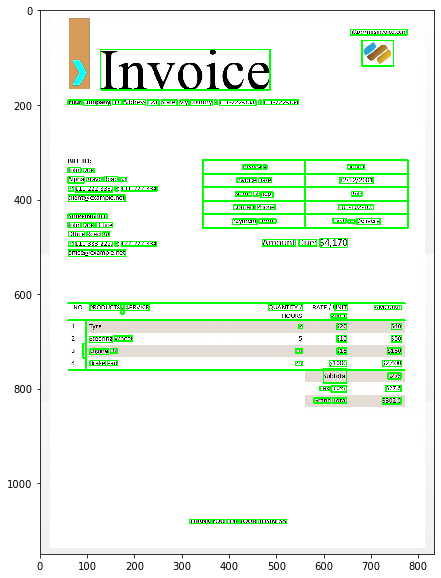

In [15]:
plt.figure(figsize = (20,10))
plt.imshow(image2, interpolation='nearest')

# Section 2: Translating the text 
- We will test translation capabilities for Chinese and Japanese languages

### Configuring Tesseract for Chinese(Simplified), Chinese(Traditional) and Japanese

In [16]:
# Adding custom options
custom_config = r'-l chi_sim+chi_tra+jpn --oem 3 --psm 6'

### Installing Required Libary for translator/Text-To-Speech

In [17]:
#Correct
#Translator
# !pip install translators --upgrade
# !pip install langdetect

#Text to Speech
# !pip install gTTS

### Import required library

In [18]:
#Translation
import translators as ts
from langdetect import detect, detect_langs

#Text To Speech
from gtts import gTTS
import os

#Audio Player
import IPython

Using state  server backend.


### Chinese (Simplified)

#### Import New Image

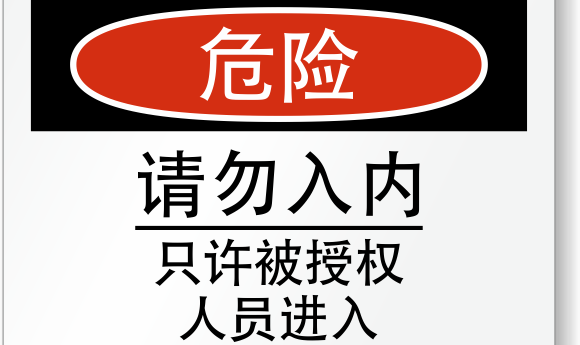

In [19]:
image3 = cv2.imread('chinese-sample.png')
Image(filename='chinese-sample.png') 

#### Run Character Recognition

In [20]:
text3 = pytesseract.image_to_string(image3, config=custom_config)
print(pytesseract.image_to_string(image3, config=custom_config))

请 勿 入 内
只 许 被 授 权
人 员 进 入



#### Translate recognised characters

In [21]:
#Detect Language in ISO693 format corresponding to language identified
result3 = detect(text3)
result3 = "zh-CN"
#Translate string identified to english
convText3 = ts.google(text3, from_language=result3, to_language='en')
print(ts.google(text3, from_language=result3, to_language='en'))

Do not enter inside 
 Only to be performed 
 Person enters


#### Convert translated text to speech

In [22]:
speech3 = gTTS(text=convText3, lang="en", slow=False)
speech3.save("Chinese(Simplified).mp3")
IPython.display.Audio("Chinese(Simplified).mp3")

### Chinese (Traditional)

#### Import New Image

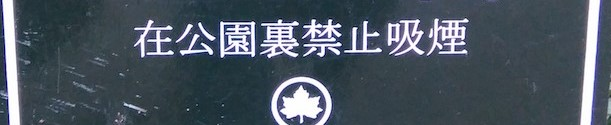

In [23]:
image4 = cv2.imread('chinese-trad-sample.jpg')
Image(filename='chinese-trad-sample.jpg') 

#### Run Character Recognition

In [24]:
text4 = pytesseract.image_to_string(image4, config=custom_config)
print(pytesseract.image_to_string(image4, config=custom_config))

ー 在 公 園 裏 禁 止 吸 煙 ′
2 ( i



#### Translate recognised characters

In [25]:
#Detect Language in ISO693 format corresponding to language identified
result4 = detect(text4)
result4 = 'zh-TW'
#Translate string identified to english
convText4 = ts.google(text4, from_language=result4, to_language='en')
print(ts.google(text4, from_language=result4, to_language='en'))

ー Anti -cigarette in the public park ′ 
 2 (i


#### Converted translated text to speech

In [26]:
speech4 = gTTS(text=convText4, lang="en", slow=False)
speech4.save("Chinese(Traditional).mp3")
IPython.display.Audio("Chinese(Traditional).mp3")

### Japanese

#### Import New Image

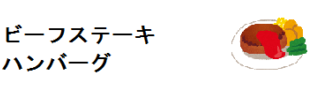

In [27]:
image5 = cv2.imread('jap-sample.png')
Image(filename='jap-sample.png') 

#### Run Character Recognition

In [28]:
text5 = pytesseract.image_to_string(image5, config=custom_config)
print(pytesseract.image_to_string(image5, config=custom_config))

ビ ピ ー フ ス テ ー キ ˍ
ハ ン バ ー グ



#### Translate Recognised Characters

In [29]:
#Detect Language in ISO693 format corresponding to language identified
result5 = detect(text5)
#Translate string identified to english
convText5 = ts.google(text5, from_language=result5, to_language='en')
print(ts.google(text5, from_language=result5, to_language='en'))

Bi -Pi Fushika ˍ 
 hamburger


#### Convert translated text to speech

In [30]:
speech5 = gTTS(text=convText5, lang="en", slow=False)
speech5.save("Japanese.mp3")
IPython.display.Audio("Japanese.mp3")

## Instant Translator

### Installing required Libraries for translation

In [31]:
#!pip install deep-translator
# !pip install detectlanguage

### Importing required libraries for translation
API Key
- https://detectlanguage.com/documentation

In [32]:
import deep_translator.exceptions
from deep_translator import GoogleTranslator, single_detection
import detectlanguage
detectlanguage.configuration.api_key = "5b9a2ceaac1e77dfd3be4c8fb03fce8b"

### Import simple image

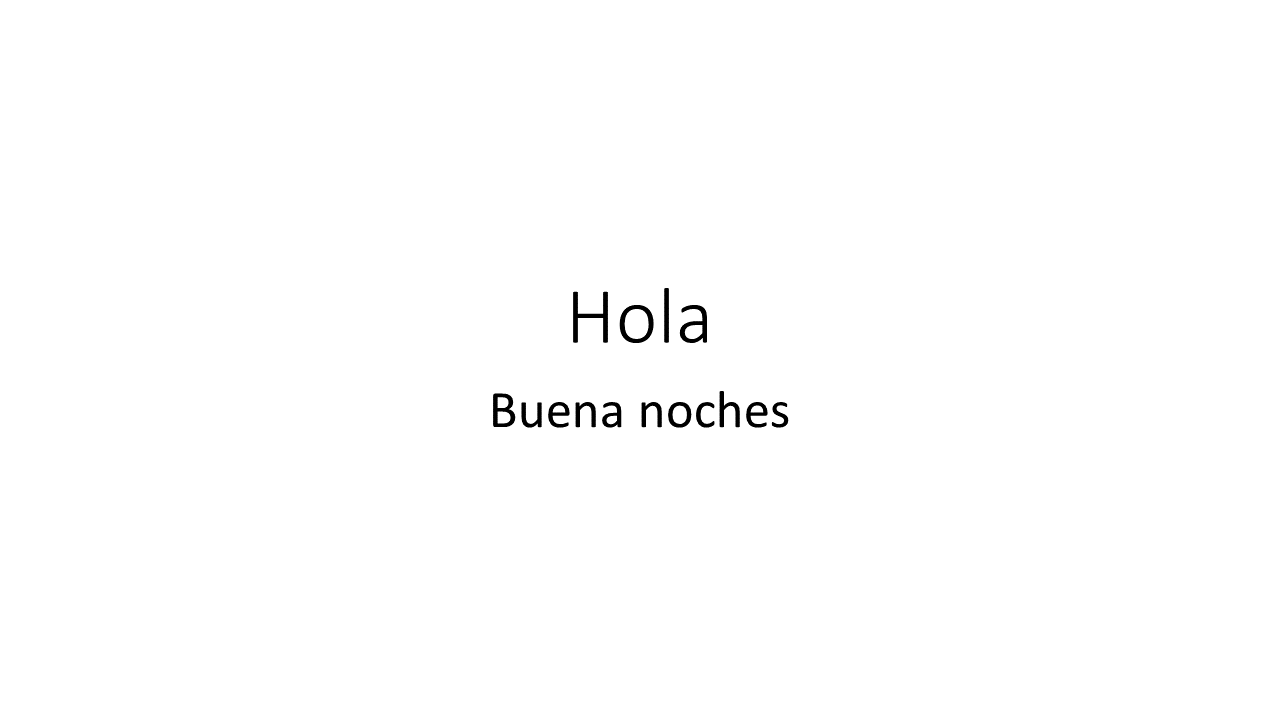

In [33]:
image5 = cv2.imread('Hola.png')
Image(filename='Hola.png') 

## Translate with picture result

In [34]:
boxes = pytesseract.image_to_data(image5)
hImg, wImg, _ = image5.shape

for x, b in enumerate(boxes.splitlines()):
    if x != 0:
        b = b.split()
        if len(b) == 12:
            x, y, w, h = int(b[6]), int(b[7]), int(b[8]), int(b[9])
            cv2.rectangle(image5, (x,y), (w + x, h + y), (0, 0, 255), 1)
            text = b[11]
            try:
                lang = single_detection(text, api_key="5b9a2ceaac1e77dfd3be4c8fb03fce8b")
                try:
                    translated_text = GoogleTranslator(source=lang, target='english').translate(text)
                    cv2.putText(image5, translated_text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 2)
                except deep_translator.exceptions.InvalidSourceOrTargetLanguage:
                    cv2.putText(image5, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            except IndexError:
                cv2.putText(image5, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            
        

cv2.imshow('Result', image5)
cv2.waitKey(0)

-1

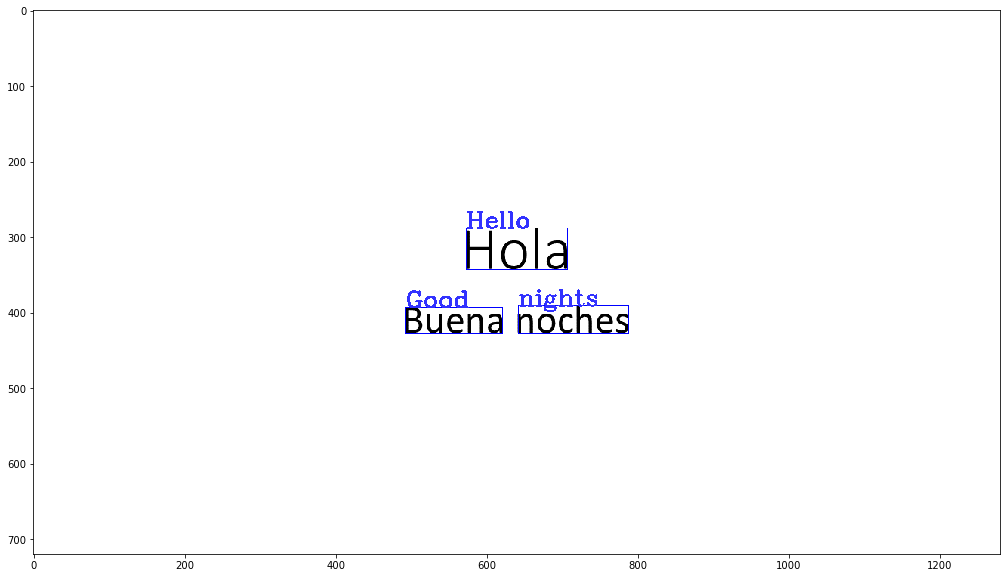

In [35]:
plt.figure(figsize = (20,10))
plt.imshow(image5, interpolation='nearest')

# 3. Combining it all together

## Import and Display Image

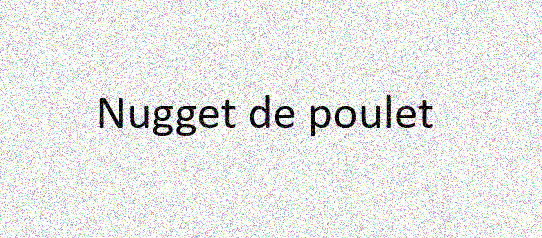

In [94]:
## Import Image and Test
image7 = cv2.imread('noisy.png')

#Display Image
Image(filename='noisy.png') 

## Image Processing
- Since the image is noisy, we will use the remove_noise() function defined earlier to remove the noise from the image, to optimise OCR

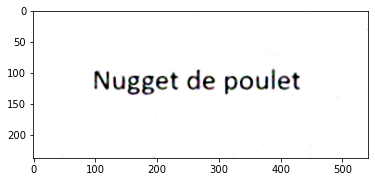

In [95]:
image7 = remove_noise(image7)
plt.imshow(image7)

In [96]:
# Run Character Recognition
text7 = pytesseract.image_to_string(image7, config=custom_config)
print(pytesseract.image_to_string(image7, config=custom_config))

Nugget de poulet



In [97]:
#Detect Language in ISO693 format corresponding to language identified
result7 = detect(text7)

#Translate string identified to english
convText7 = ts.google(text7, from_language=result7, to_language='en')
print(ts.google(text7, from_language=result7, to_language='en'))

Chicken nugget


## Output 1: Voice Output

In [98]:
speech7 = gTTS(text=convText7, lang="en", slow=False)
speech7.save("Combined.mp3")
IPython.display.Audio("Combined.mp3")

## Output 2: Image Output

In [99]:
boxes = pytesseract.image_to_data(image7)
hImg, wImg, _ = image7.shape

for x, b in enumerate(boxes.splitlines()):
    if x != 0:
        b = b.split()
        if len(b) == 12:
            x, y, w, h = int(b[6]), int(b[7]), int(b[8]), int(b[9])
            cv2.rectangle(image7, (x,y), (w + x, h + y), (0, 0, 255), 1)
            text = b[11]
            try:
                lang = single_detection(text, api_key="5b9a2ceaac1e77dfd3be4c8fb03fce8b")
                try:
                    translated_text = ts.google(text, source=lang, to_language='en')
                    cv2.putText(image7, translated_text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 2)
                except deep_translator.exceptions.InvalidSourceOrTargetLanguage:
                    cv2.putText(image7, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            except IndexError:
                cv2.putText(image7, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            
        

cv2.imshow('Result', image7)
cv2.waitKey(0)

-1

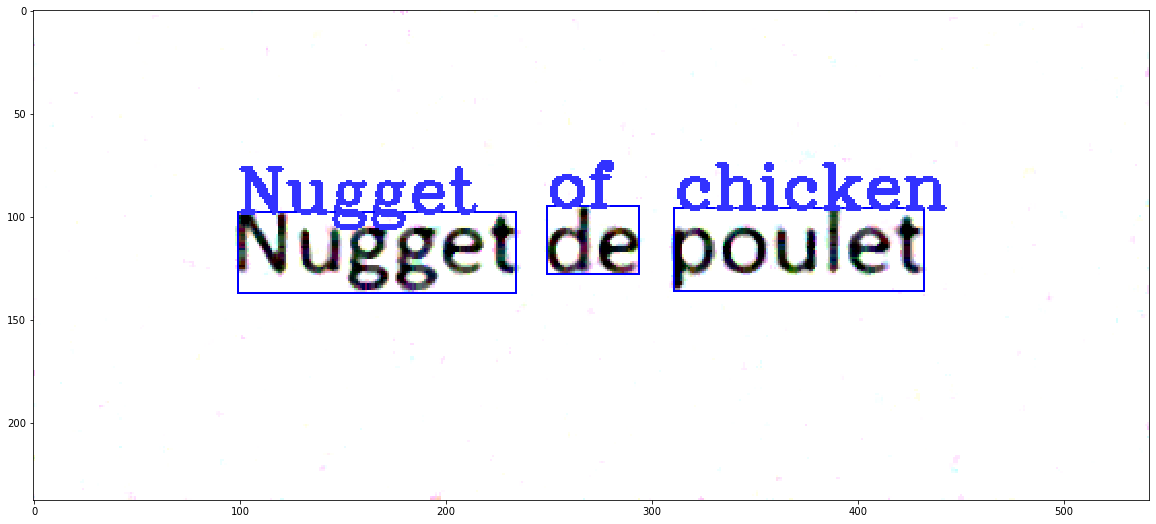

In [100]:
plt.figure(figsize = (20,10))
plt.imshow(image7, interpolation='nearest')